In [1]:
%%HTML
<script src="require.js"></script>

In [2]:
from IPython.display import HTML
HTML(
    """
    <script
        src='https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js'>
    </script>
    <script>
        code_show=true;
        function code_toggle() {
        if (code_show){
        $('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
        } else {
        $('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
        }
        code_show = !code_show
        }
        $( document ).ready(code_toggle);
    </script>
    <form action='javascript:code_toggle()'>
        <input type="submit" value='Click here to toggle on/off the raw code.'>
    </form>
    """
)

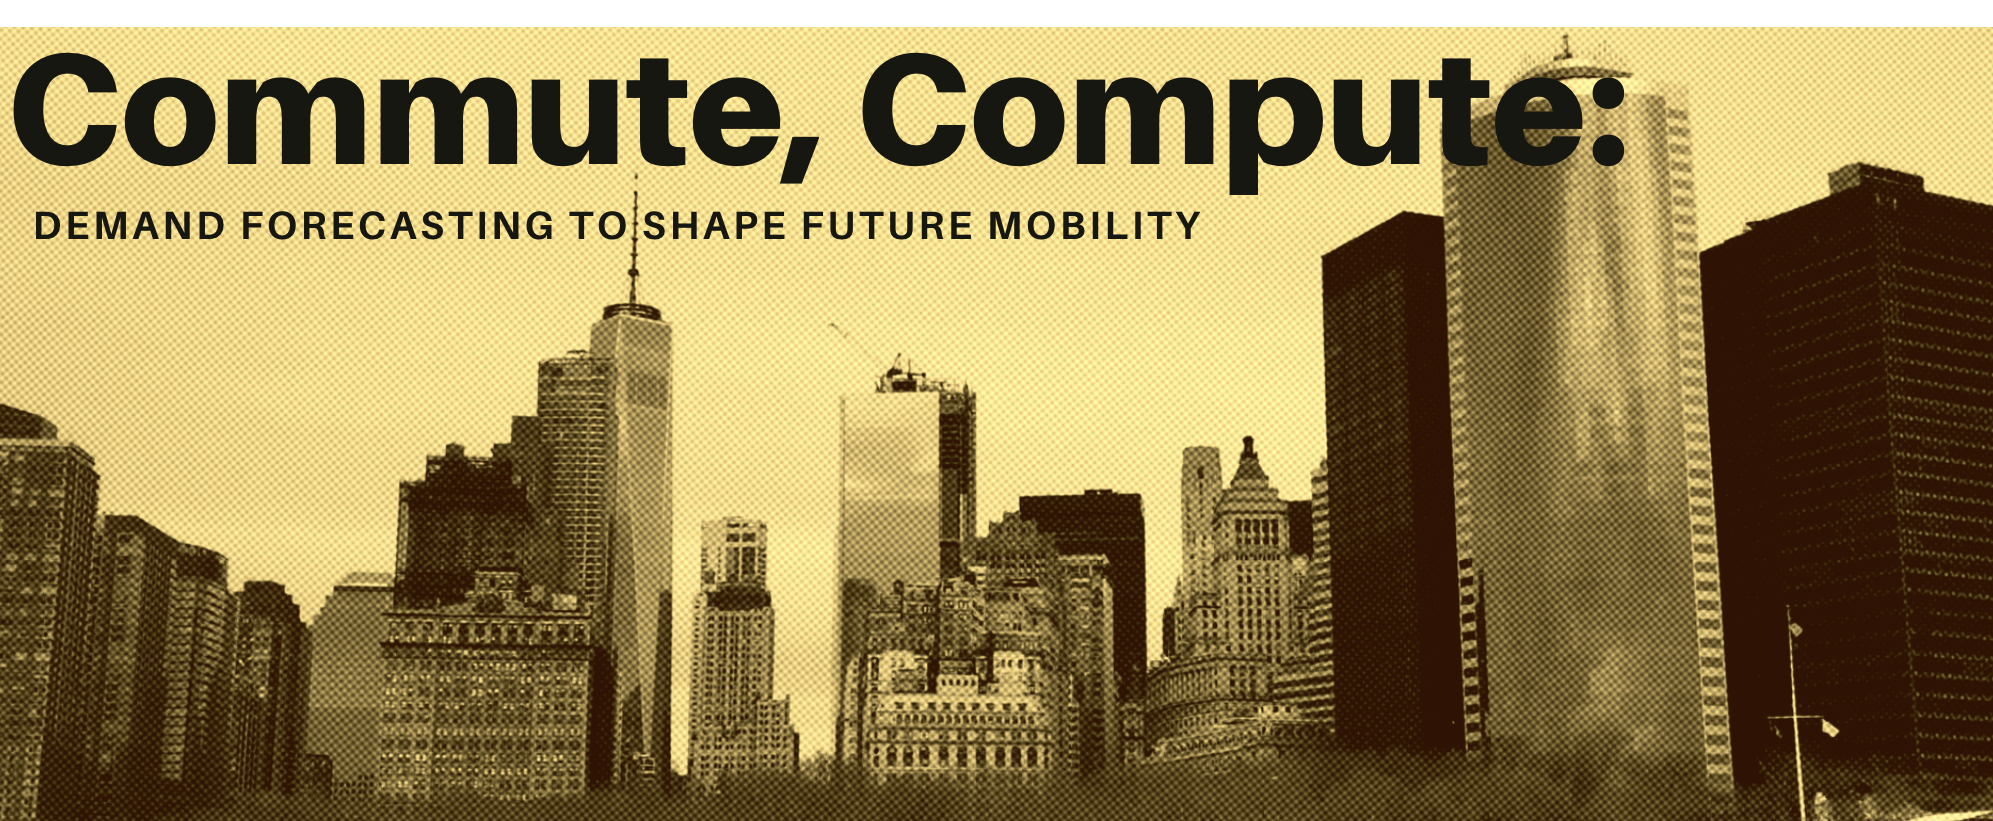

<a id='Title'></a>
<h1 style="color:#000000; background-color:#f7b731; padding: 20px 0; text-align: center; font-weight: bold;">I. Abstract</h1><a id='ExecSum'></a><a id='Title'></a><a id='Title'></a>

This project forecasts the aggregate taxi demand for all of New York City for a given given pick-up location, day, and hour, seven days in advance. This was achieved using a hybrid ML approach. The dataset was partitioned into subsets which each contain the unique data for a given zone, day of the week, and hour of the day. On each subset, models were trained, hyperparameter tuned, and tested in parallel, producing a system containing approximately 43000 unique models. The test MAE of each node was collected, producing an overall average MAE of 16.2 which represents a 14.6% reduction in MAE compared to the naive baseline. This hybrid system demonstrated effectiveness not only in reducing MAE, but also in computational efficiency through the effective use of parallel computing, as opposed to training a single over-arching model on the entire dataset. This project could benefit from incorporating taxi supply data and weather data, and further exploring more complex models could provide new insights.



<a id='Title'></a>
<h1 style="color:#000000; background-color:#f7b731; padding: 20px 0; text-align: center; font-weight: bold;">II. Problem Statement</h1><a id='ExecSum'></a><a id='Title'></a><a id='Title'></a>

This project presents a possible answer to the question: *how do we produce a model that accurately forecasts hourly taxi demand seven days in advance while optimizing the use of computational resources?*

The dual objectives are necessary for project success. The former is to ensure that the model produces value for urban planning, while the latter ensures that the model is produceable, given the enormous amount of data required to train the model. This means that the project must identify how parallel computing and other techniques can be leveraged to handle the large volume of data without compromising on performance or scalability.

<a id='Title'></a>
<h1 style="color:#000000; background-color:#f7b731; padding: 20px 0; text-align: center; font-weight: bold;">III. Motivation</h1><a id='ExecSum'></a><a id='Title'></a><a id='Title'></a>

Accurate forecasting of taxi demand across New York City provides policymakers with critical insights into urban mobility patterns, enabling more informed decisions on transportation planning and infrastructure development. By anticipating taxi pickup volumes in advance, policymakers can optimize resource allocation, enhance traffic management, and improve overall urban planning strategies to better meet the city's transportation needs.

<a id='Title'></a>
<h1 style="color:#000000; background-color:#f7b731; padding: 20px 0; text-align: center; font-weight: bold;">IV. Data Source Description</h1><a id='ExecSum'></a><a id='Title'></a><a id='Title'></a>

The orginal data source used for this project is New York City (NYC) Taxi and Limousine Commission (TLC) Trip Record Data for Yellow Taxis, Green Taxis, For-Hire Vehicle (“FHV”) and High Volume For-Hire Vehicle (“FHVHV”). The data was accessed from the AWS Marketplace as part of the AWS Open Data Sponsorship Program. 

This notebook begins from loading the output of the preprocessing notebook. The original data was transformed, cleaned, merged and partially aggregated (see the previous notebook for more details on the original data and the preprocessing steps). 

From an original 1.9 billion trips, the preprocessed data to be loaded was aggregated to 17.0 million rows. The data spans from 2015-2023H1. Its metadata is described below:

| Column  | Data Type |Description                                              |
|-------------|-----------|----------------------------------------------------------|
| pu_id       | Integer   | The ID of the pickup location for NYC taxi data.         |
| date_day    | DateTime  | The exact date and time when the pickup occurred.        |
| Year        | Integer   | The year when the pickup occurred.                       |
| Month       | Integer   | The month when the pickup occurred.                      |
| DayOfWeek   | String    | The day of the week when the pickup occurred.            |
| HourOfDay   | Integer   | The hour of the day when the pickup occurred.            |
| is_Holiday  | Integer   | Indicates whether the day is a holiday (0 for no, 1 for yes). |
| count       | Integer   | The number of trips that occurred from the pickup location. |
<center><b>Table 1. </b> Metadata</center>

<a id='Title'></a>
<h1 style="color:#000000; background-color:#f7b731; padding: 20px 0; text-align: center; font-weight: bold;">V. Methodology Overview</h1><a id='ExecSum'></a><a id='Title'></a><a id='Title'></a>

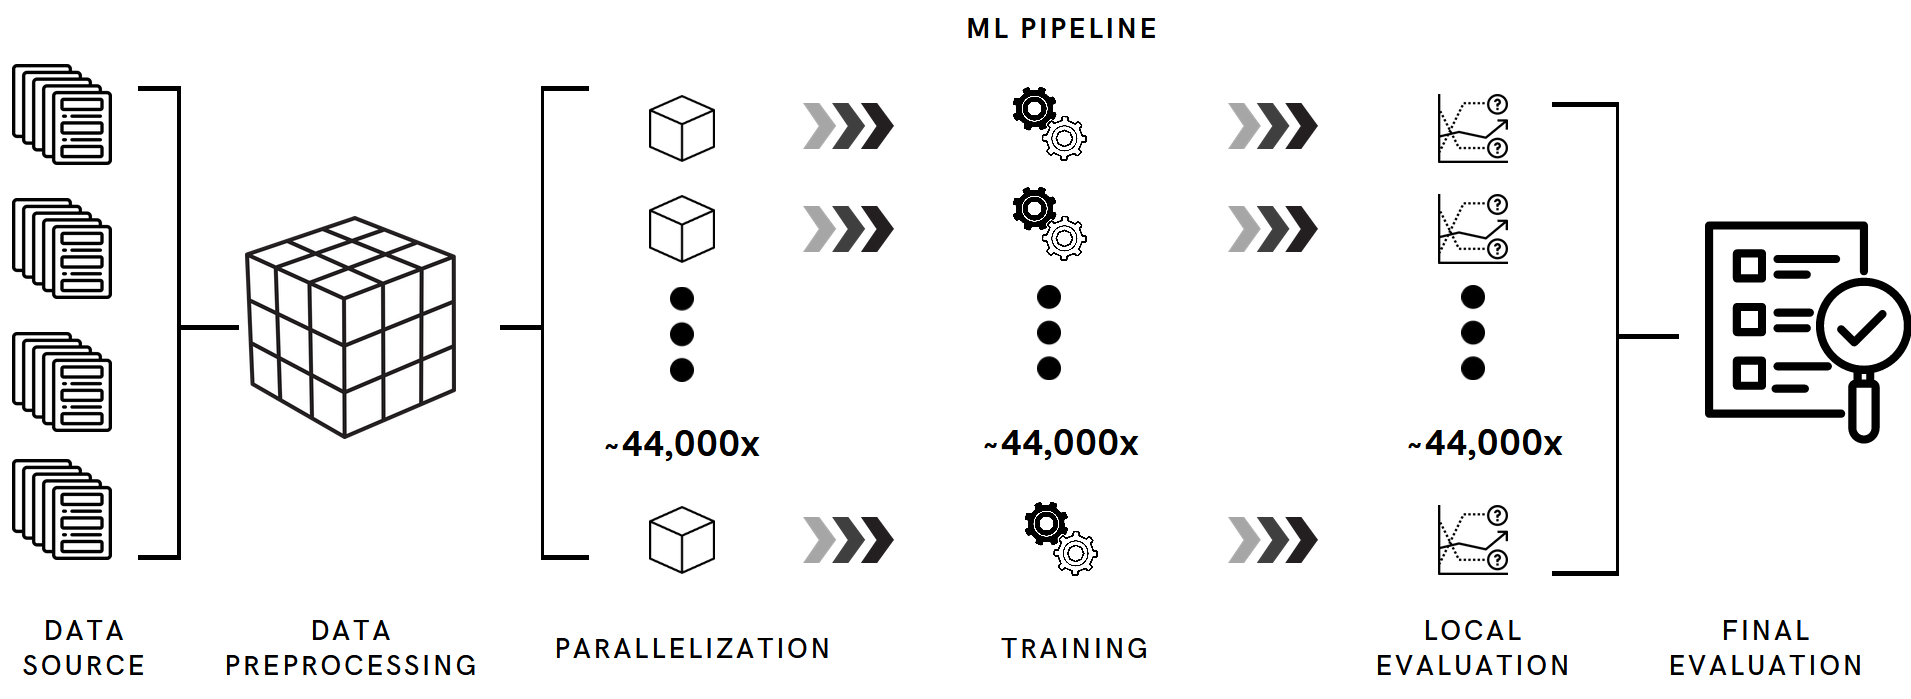

| Task | Subtask | Description                                              |
|-------------|-----------|----------------------------------------------------------|
| **Preprocessing**|Cleaning| Cleaning the raw data by filtering incomplete data and conforming the column names and data types to a uniform schema. |
|| Feature Extraction   | Obtain time-related features by reading data files for different vendors from an S3 bucket, processing each file by transforming specific columns to desired data types, and saves the transformed data to a new location in the S3 bucket. This process extracts features such as timestamps, IDs, counts, dates, day of the week, month, hour, year, and holiday status. |
|| Merge, Partition and Write   | Merge the datasets into a unified data repository of Parquet files in storage, strategically partitioned for efficient reading and querying operations. The data is read into a unified Spark DataFrame, processed, and written to storage as Parquet files partitioned by `pu_id` and `HourOfDay` for optimal balance between file management and query performance. This partitioning choice ensures efficient reading and querying for downstream analysis, model training, and prediction development. |
||  Data Load and Aggregate  |Load preprocessed data from S3 Bucket and group by `pu_id`, `date` and `hour`, while aggregating the count of the trips.|
|**ML Pipeline**|applyInPandas| Group the data by `pu_id`, `hour`, and `day of week` to enable parallelization in PySpark.|
||Train-Test Split| For each parallel subset, split the data with an 80-20 split.|
||Hyperparameter Tune|Obtain the best model for the given subset using Grid Search on Linear Regression, Ridge, Lasso, Random Forest Regressor, and Gradient Boosting Regressor.|
||Predict|Obtain test predictions for the number of trips per `zone`, `DayOfWeek`, `HourOfDay`.|
||Evaluate|Obtain local MAE.|
|**Final Evaluation**||Obtain the aggregate MAE of the entire hybrid system and compare it to the naive MAE. Performance by Nodes, Feature Importances, Frequent Models, and Example Schedules are also explored in the evaluation.|
<center><b>Table 2. </b> Methodology</center>

## V.A. Spark Setup and Imports

This sets up the Spark context and imports the necessary libraries.

In [1]:
sc

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<SparkContext master=yarn appName=livy-session-0>

In [2]:
sc.install_pypi_package('pyspark')
sc.install_pypi_package('sklearn')
sc.install_pypi_package('pandas')
sc.install_pypi_package('numpy')
sc.install_pypi_package('pyarrow==4.0.0')

sc.install_pypi_package('boto3')
sc.install_pypi_package('s3fs')
sc.install_pypi_package('seaborn')
sc.install_pypi_package('python-dateutil==2.8.2')
sc.install_pypi_package('matplotlib')
sc.install_pypi_package('geopandas')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
spark._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "s3.amazonaws.com")
spark._jsc.hadoopConfiguration().set("fs.s3a.path.style.access", "true")
spark._jsc.hadoopConfiguration().set(
    "fs.s3a.access.key", "****")
spark._jsc.hadoopConfiguration().set(
    "fs.s3a.secret.key", "****")
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
import pandas as pd
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 24)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## V.B. Load Data

Data is loaded and aggregated to the most granular level necessary to reduce memory and computational expense downstream. Each row represents a unique  timestamp containing the specific date and hour for a specific Pick-Up ID. The count is the number of trips that occurred.  

In [5]:
from pyspark.sql import functions as F
from pyspark.sql.functions import rank, col

s3_path = "s3://<personal bucket>/trips0/"

data = spark.read.parquet(s3_path) \
    .filter("Year > 2014") \
    .na.drop() \
    .withColumn('date_day', F.col('date_day').cast('timestamp')) \
    .groupBy(
        "pu_id", "date_day", "Year", "Month", "DayOfWeek", "HourOfDay",
        "is_Holiday"
    ) \
    .agg(F.sum("count").alias("count"))

data.persist()
data.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-------------------+----+-----+---------+---------+----------+-----+
|pu_id|           date_day|Year|Month|DayOfWeek|HourOfDay|is_Holiday|count|
+-----+-------------------+----+-----+---------+---------+----------+-----+
|255.0|2015-11-04 00:00:00|2015|   11|      Wed|       17|         0|   79|
|255.0|2019-02-15 00:00:00|2019|    2|      Fri|       17|         0|  315|
|255.0|2015-07-20 00:00:00|2015|    7|      Mon|       19|         0|  157|
|255.0|2018-05-01 00:00:00|2018|    5|      Tue|       19|         0|  327|
|255.0|2019-06-05 00:00:00|2019|    6|      Wed|       19|         0|  348|
+-----+-------------------+----+-----+---------+---------+----------+-----+
only showing top 5 rows

<center><b>Table 3. </b> Filtered Data Head</center>

In [6]:
print("Shape:")
print((data.count(), len(data.columns)))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Shape:
(16989370, 8)

<a id='Title'></a>
<h1 style="color:#000000; background-color:#f7b731; padding: 20px 0; text-align: center; font-weight: bold;">VI. Exploratory Data Analysis (EDA)</h1><a id='ExecSum'></a><a id='Title'></a><a id='Title'></a>

### VI.A. Total Number of Trips

We collect and display the total number of trips, totalling 1.9 Billion, that we will be working on.

In [7]:
data.agg(F.sum("count").alias("Total_Count")).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+
|Total_Count|
+-----------+
| 1935741448|
+-----------+

<center><b>Table 4. </b> Trip Count</center>

### VI.B. Visualizing Taxi Zones

We visualize the larger Service Zone group of each zone in New York to possibly identify any patterns or insights on how the zones are grouped.

In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt

shapefile_path = "s3://<personal bucket>/zones/taxi_zones.shp"
lkp_path = "s3://<personal bucket>/taxi_zones_lookup.csv"
taxi_zones = gpd.read_file(shapefile_path)
taxi_zones = taxi_zones.merge(
    pd.read_csv(lkp_path), how='left', left_on='OBJECTID',
                              right_on='LocationID')

# Plotting
taxi_zones.plot(column='service_zone', ax=ax, legend=True,
                legend_kwds={'title': 'Service Zone'},
                categorical=True, cmap='viridis')

plt.title('NYC Service Zones')
ax.set_axis_off()
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

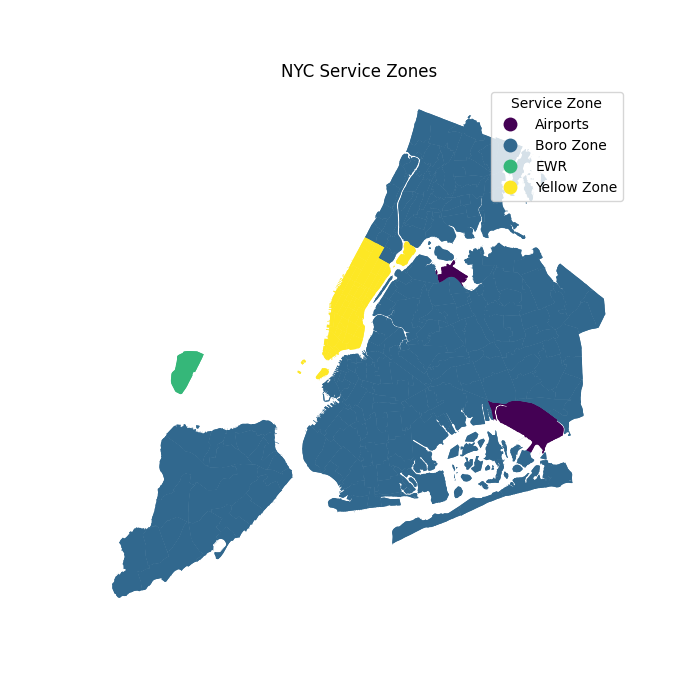

In [10]:
%matplot plt

<center><b>Figure 1. </b> NYC Service Zones</center>

### VI.C. Visualizing Demand by Zone 

We sampled data during a New York Weekday Rush Hour where we filter the data to show trips for an example, on June 6 Mondays 7 to 10am. We display a heatmap of the frequency of trips per zone and it shows how each zone varies in frequency. 

In [8]:
pu_eda = data.filter((data['HourOfDay'] >= 7) &
                     (data['HourOfDay'] <= 10) &
                     (data['DayOfWeek'] == 'Mon') &
                     (data['is_Holiday'] == 0) &
                     (data['Month'] == 6) &
                     (data['Year'] == 2022)
                     ) \
    .groupby("pu_id") \
    .agg(F.sum('count').alias('trips')).collect()

df_eda_morning = spark.createDataFrame(pu_eda).toPandas()
df_eda_morning['trips'] = (df_eda_morning['trips'] /
                           df_eda_morning['trips'].sum())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt

shapefile_path = "s3://<personal bucket>/zones/taxi_zones.shp"
taxi_zones = gpd.read_file(shapefile_path)
taxi_zones = taxi_zones.merge(df_eda_morning, how='left', left_on='OBJECTID',
                              right_on='pu_id')

# Fill NaN values with 0 where there is no match
taxi_zones['trips'] = taxi_zones['trips'].fillna(0)

# # Plotting
fig, ax = plt.subplots(figsize=(7, 7))  
taxi_zones.plot(column='trips', ax=ax, edgecolor='black', cmap='viridis', 
                legend=True)

# Adding a color bar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(
    vmin=taxi_zones['trips'].min(), vmax=taxi_zones['trips'].max()))
sm._A = [] 
plt.title('NYC Weekday Rush Hour')
ax.set_axis_off()
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

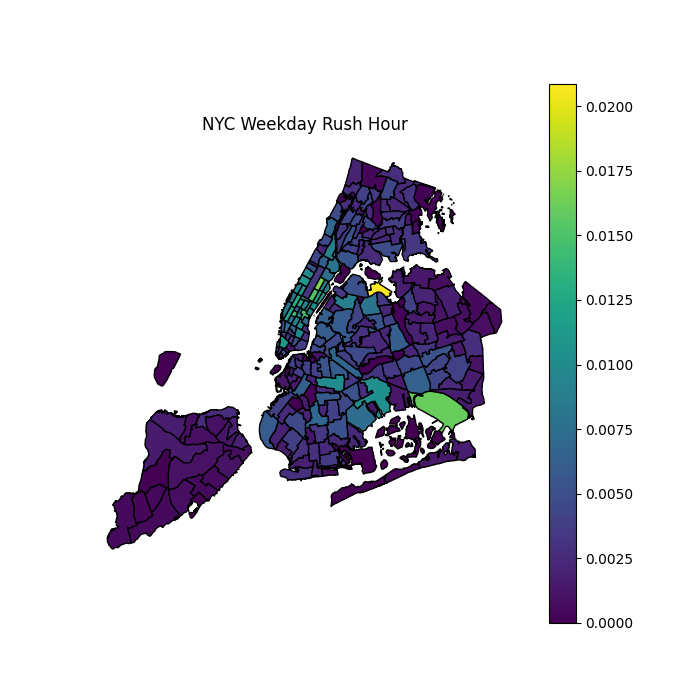

In [12]:
%matplot plt

<center><b>Figure 2. </b> NYC Weekday Rush Hour Heatmap</center>

### VI.D. Visualizing Hourly Demand

We filter the data for weekdays and weekends, then compare for hourly trips of each day.
This shows the taxi trips vary considerably depending on the time and day.

In [13]:
from pyspark.sql.functions import col, when

weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
weekends = ['Sat', 'Sun']

df_ts = data.filter((col("is_Holiday") == 0) &
                    (col('Month') == 6) &
                    (col('Year') == 2022)
                   ) \
        .groupby("HourOfDay").agg(
            F.sum(when(col("DayOfWeek").isin(weekdays), col("count"))) \
                .alias("weekday_trips"),
            F.sum(when(col("DayOfWeek").isin(weekends), col("count"))) \
                .alias("weekend_trips")
        )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
import matplotlib.pyplot as plt

# Convert to Pandas DataFrame
df_ts = df_ts.toPandas()

# Sort the DataFrame by 'HourOfDay' for proper line plotting
df_ts.sort_values('HourOfDay', inplace=True)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_ts['HourOfDay'], df_ts['weekday_trips'],
         label='Weekday Trips', marker='o')
plt.plot(df_ts['HourOfDay'], df_ts['weekend_trips'],
         label='Weekend Trips', marker='o')

plt.title('Trips by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.legend()
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

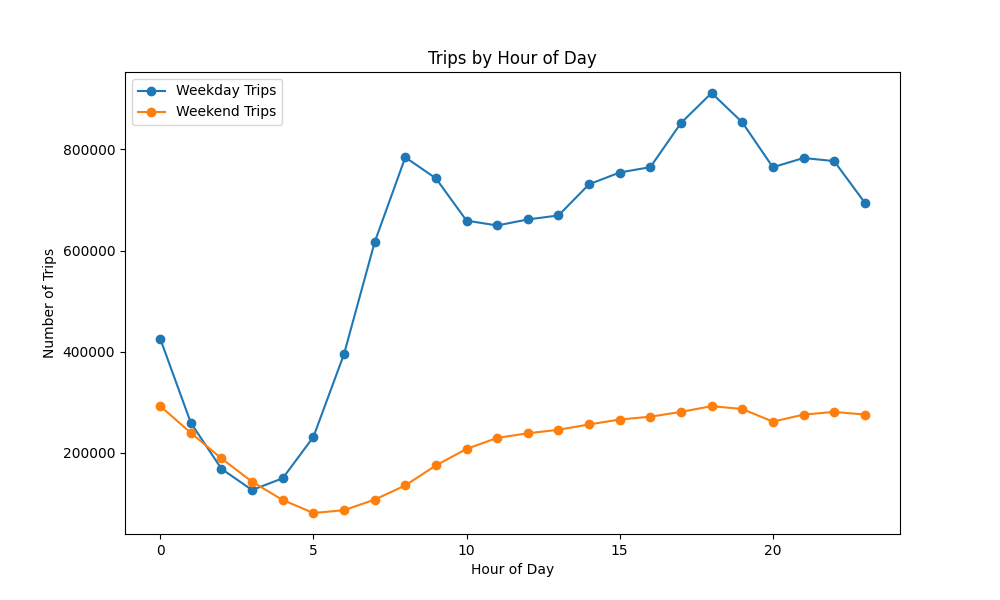

In [15]:
%matplot plt

<center><b>Figure 3. </b>Trips by Hour of Day (Weekday vs Weekend)</center>

<a id='Title'></a>
<h1 style="color:#000000; background-color:#f7b731; padding: 20px 0; text-align: center; font-weight: bold;">VII. Hybrid ML Pipeline</h1><a id='ExecSum'></a><a id='Title'></a><a id='Title'></a>

The code below trains approximately 43,000 models in parallel. Each model is solely dedicated for predicting a specific pu_id, DayOfWeek, and HourOfDay combination. This means that there is only one model used to predict demand on Mondays at 8AM at JFK, and another model to predict Tuesday at 8AM at JFK. 

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error


def train_evaluate_models(df):
    """
    Train and evaluate multiple regression models on a given dataset to 
    predict future values based on historical data.

    The function takes a DataFrame `df` which must include specific columns
    for processing and feature engineering. It sorts the data, creates lag 
    features, splits the data into training and test sets, and uses a pipeline
    to scale data and fit multiple regression models with hyperparameter 
    tuning using grid search. The best model is then evaluated using several 
    metrics and its next prediction is returned along with model details.

    Parameters:
    df (pd.DataFrame): A DataFrame containing at least the following columns:
                       'pu_id', 'DayOfWeek', 'HourOfDay', 'date_day', 'count'.

    Returns:
    pd.DataFrame: A DataFrame containing the results of the best model 
                  evaluation. If an exception occurs, returns a DataFrame with
                  zeroed statistics and empty model details.

    Raises:
    Exception: Catches exceptions that may occur during model training or 
    evaluation and returns a DataFrame with default values.
    """

    pu_id, dow, hod = df['pu_id'][0], df['DayOfWeek'][0], df['HourOfDay'][0]

    try:

        # Sort by date
        df = df.sort_values(by='date_day')

        # Create lags
        for i in range(1, 4):
            df[f'lag{i}'] = df['count'].shift(i)

        # Removes first rows where lags unavailable
        df = df.iloc[3:].reset_index(drop=True).reset_index(drop=False)

        # Declare features and target
        X_cols = ['index', 'Month', 'is_Holiday',
                  'lag1', 'lag2', 'lag3']
        y_col = 'count'

        # Save the total_count and avg_count
        total_count = df[y_col].sum()
        avg_count = df[y_col].mean()

        # Create row for the next prediction in 7 days
        X_pred = df.iloc[-1:]
        X_pred['index'] += 1
        X_pred.is_Holiday = 0
        X_pred.lag3 = X_pred.lag2
        X_pred.lag2 = X_pred.lag1
        X_pred.lag1 = X_pred['count']
        X_pred = X_pred[X_cols]

        # Train test split
        X_train, X_test, y_train, y_test = train_test_split(df[X_cols],
                                                            df[y_col],
                                                            test_size=0.2,
                                                            shuffle=False)
        del df

        # Pipeline
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', LinearRegression())
        ])

        # Define the parameter grid
        param_grid = [
            {'regressor': [LinearRegression()],
             'regressor__fit_intercept': [True]},
            {'regressor': [Ridge()],
             'regressor__alpha': [0.1, 1.0, 2.0]},
            {'regressor': [Lasso()],
             'regressor__alpha': [0.1, 1.0, 2.0]},
            #             {'regressor': [RandomForestRegressor()],
            #              'regressor__n_estimators': [100]},
            #             {'regressor': [GradientBoostingRegressor()],
            #              'regressor__max_depth': [7]}
        ]

        # Set up the grid search with 4-fold cross-validation
        grid_search = GridSearchCV(pipe,
                                   param_grid,
                                   cv=4,
                                   scoring='neg_mean_squared_error',
                                   verbose=0,
                                   n_jobs=-1)
        grid_search.fit(X_train, y_train)

        # Best parameters found
        best_model = grid_search.best_estimator_
        model_name = grid_search.best_params_['regressor'].__class__.__name__
        predictions = best_model.predict(X_test)
        naive_predictions = X_test.lag1
        mape = mean_absolute_percentage_error(y_test, predictions)
        naive_mape = mean_absolute_percentage_error(y_test, naive_predictions)
        avg_error = (y_test - predictions).mean()
        mae = mean_absolute_error(y_test, predictions)
        naive_mae = mean_absolute_error(y_test, naive_predictions)
        next_pred = best_model.predict(X_pred)[0]

        coefficients = best_model.named_steps['regressor'].coef_

        return pd.DataFrame(
            [[pu_id, dow, hod, model_name, avg_count, next_pred,
              total_count, predictions.sum(),  mape, naive_mape,
              mae, naive_mae, avg_error, coefficients]],
            columns=['pu_id', 'DayOfWeek', 'HourOfDay', 'best_model',
                     'avg_count', 'next_pred', 'total_count', 'pred_count',
                     'test_mape', 'naive_mape', 'test_mae', 'naive_mae',
                     'test_avgerror', 'coefs']
        )
    except Exception as e:
        return pd.DataFrame(
            [[pu_id, dow, hod, '', 0, 0,
              0, 0, 0, 0,
              0, 0, 0, None]],
            columns=['pu_id', 'DayOfWeek', 'HourOfDay', 'best_model',
                     'avg_count', 'next_pred', 'total_count', 'pred_count',
                     'test_mape', 'naive_mape', 'test_mae', 'naive_mae',
                     'test_avgerror', 'coefs']
        )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
results = (data
           .groupby(['pu_id', 'HourOfDay', 'DayOfWeek'])
           .applyInPandas(
               train_evaluate_models,
               schema="""
               pu_id DOUBLE,
               DayOfWeek STRING,
               HourOfDay INT,
               best_model STRING,
               avg_count DOUBLE,
               next_pred DOUBLE,
               total_count DOUBLE,
               pred_count DOUBLE,
               test_mape DOUBLE,
               naive_mape DOUBLE,
               test_mae DOUBLE,
               naive_mae DOUBLE,
               test_avgerror DOUBLE,
               coefs ARRAY<DOUBLE>
               """)
          ).collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### VII.A. Save Results

We save the dataframe of test results into a csv file.

In [18]:
df = pd.DataFrame([row.asDict() for row in results])
path = 's3://<personal bucket>/results_test3.csv'
df.to_csv(path, index=False)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<a id='Title'></a>
<h1 style="color:#000000; background-color:#f7b731; padding: 20px 0; text-align: center; font-weight: bold;">VIII. Evaluation</h1><a id='ExecSum'></a><a id='Title'></a><a id='Title'></a>

The output of the ML pipeline is a dataframe evaluating each model. A truncated output might resemble below:

| Name                     | Description        | 
|--------------------------|-------------------|
|pu_id|Pick-Up ID.|
|DayOfWeek|Day of the Week (eg. Mon, Tue, Wed, etc.)|
|HourOfDay|Hour of the Day (i.e. 0-23)|
|best_model|The best model for a specific pu_id, DayOfWeek, HourOfDay subset.|
|test_mae|The test MAE of the given model and subset.|
|naive_mae|The naive MAE of the given subset.|
|next_pred|The predicted demand in exactly 7-days (168 hours) from the last point.|

<center><b>Table 5. </b> Output Metadata</center>

In [19]:
import pandas as pd
path = 's3://<personal bucket>/results_test3.csv'
df = pd.read_csv(path).dropna()
df = df.rename(columns={'avg_count': 'avg_trips',
                       'test_mae': 'mae'})

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### VIII.A. Performance by Node

The output below returns the highest volume nodes in terms of average trips by `zone`, `DayOfWeek`, and `HourOfDay`. The `mae` and `naive_mae` are also included in the table.

In [20]:
path = "s3://<personal bucket>/taxi_zones_lookup.csv"
df_zones = pd.read_csv(path)

df = df.merge(df_zones[['LocationID', 'Zone']],
              left_on='pu_id', right_on='LocationID', how='left')
df.drop(['LocationID', 'pu_id'], axis=1, inplace=True)

df['Name'] = df['Zone'] + ': ' + df['DayOfWeek'] + \
    ' @ ' + df['HourOfDay'].astype(str)
cols = ['Name', 'best_model', 'avg_trips', 'mae', 'naive_mae']

print('Highest Volume Nodes')
df.sort_values(by='total_count', ascending=False)[cols].head(10).round(1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Highest Volume Nodes
                           Name        best_model  avg_trips    mae  naive_mae
33895     East Village: Sun @ 1  LinearRegression     1779.2  348.3      354.8
38057     East Village: Sat @ 1  LinearRegression     1681.4  280.0      306.7
14373     East Village: Sun @ 0             Lasso     1675.9  243.3      263.9
28313     East Village: Sat @ 0             Ridge     1616.0  228.1      254.7
7388     East Village: Sat @ 23             Lasso     1544.8  212.3      238.8
4607      East Village: Sun @ 2  LinearRegression     1524.1  352.7      383.5
8799     East Village: Fri @ 23  LinearRegression     1500.4  196.2      216.9
12995     East Village: Sat @ 2  LinearRegression     1475.9  265.2      297.5
14712  Lower East Side: Sun @ 1             Ridge     1432.9  257.3      263.3
12996    East Village: Sat @ 22             Lasso     1386.1  218.5      247.1

<center><b>Table 6. </b> Nodes with Highest Volume of Trips</center>

In [21]:
print(f"MAE Stdev: {df.mae.std():.3f}")
print("Model Improvement Frequency: ",
      sum(df.naive_mae > df.mae)/len(df.mae):.3f})

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

MAE Stdev: 20.064
Model Improvement Frequency: 0.942

In [22]:
import matplotlib.pyplot as plt

plt.hist(df['mae'], bins=10, color='blue', edgecolor='black')
plt.title('Histogram of MAE')
plt.xlabel('MAE')
plt.ylabel('Frequency')
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

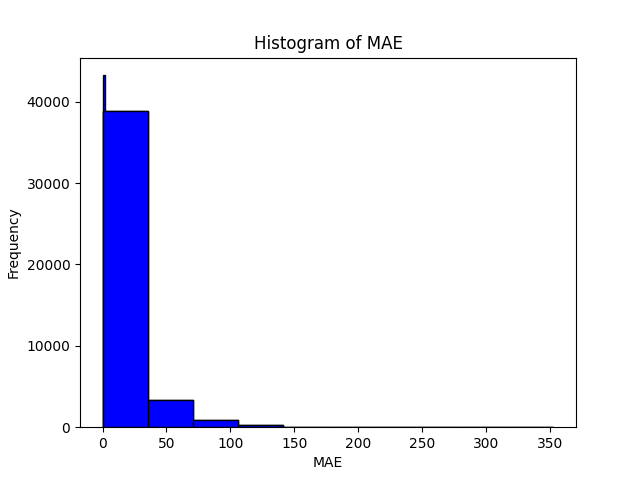

In [23]:
%matplot plt

<center><b>Figure 4. </b> Histogram of MAE</center>

This histogram plot shows the frequency of the MAEs. This shows the model does not make a lot of errors due to the frequencies concentrating on the lower end of the plot. It signifies the model is generally accurate.

### VIII.B. Overall System Performance

A system MAE of 16.2 was obtained compared to a naive baseline of 19.0. This represents a **14.6%**  improvement.

In [24]:
test_mae = df.mae.mean()
naive_mae = df.naive_mae.mean()

print(f"MAE: {test_mae:0.4f}")
print(f"Naive MAE: {naive_mae:0.4f}")
print(f"Change (%) in MAE: {(test_mae/naive_mae-1)*100:0.1f}%")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

MAE: 16.1973
Naive MAE: 18.9570
Change (%) in MAE: -14.6%

### VIII.C. Feature Importances

The average feature importances were collected, though it should be noted that these can vary significantly by model. For example, the impact of holidays may be more significant for airports than zones far from the NYC core.

In [25]:
import ast

df['coefs'] = df['coefs'].apply(ast.literal_eval)
df_coefs = df[df['coefs'].apply(lambda x: isinstance(x, list))].coefs
df_expanded = df['coefs'].apply(pd.Series)
X_cols = ['Week_Index', 'Month', 'is_Holiday',
          'lag_1weeks', 'lag_2weeks', 'lag_3weeks']
df_expanded.columns = X_cols

mean_coefs = np.abs(df_expanded).mean() / np.abs(df_expanded).mean().sum()
print("Scaled Feature Importances")
mean_coefs

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Scaled Feature Importances
Week_Index    0.040671
Month         0.018448
is_Holiday    0.081735
lag_1weeks    0.479535
lag_2weeks    0.203092
lag_3weeks    0.176520
dtype: float64

### VIII.D. Frequent Models

It would found that Linear Regression models were most commonly used to predict trips, however, Lasso models were the most common in terms of model count. Ridge models, though less common, were still significant in frequency.

In [26]:
best_models = pd.DataFrame(df.best_model.value_counts()) \
    .rename(columns={'count': 'Model Count'})
best_models.index.name = 'Model'
best_models['Model Count'] = best_models['Model Count']
best_models['Rel Model Count'] = best_models['Model Count'] / best_models[
    'Model Count'].sum()

df_models = df.groupby('best_model') \
            .agg(total_count=('total_count', 'sum')) \
            .rename(columns={'total_count': 'Trip Count'}) \
            .merge(best_models, left_index=True, right_index=True)

df_models[
    'Rel Trip Count'] = df_models['Trip Count'] / df_models[
'Trip Count'].sum()
df_models[['Trip Count', 'Rel Trip Count', 'Model Count', 'Rel Model Count']] \
    .sort_values(by='Trip Count', ascending=False) \
    .round(3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                   Trip Count  Rel Trip Count  Model Count  Rel Model Count
best_model                                                                 
LinearRegression  860438693.0           0.447        14909            0.342
Lasso             804442971.0           0.418        20405            0.469
Ridge             261196330.0           0.136         8219            0.189

<center><b>Table 7. </b> Best Models based on Trip Counts</center>

### VIII.E. Example Schedule using Forecast

The system is able to produce forecasts for any `Zone`, `DayOfWeek`, and `HourOfDay`, 7 days in advance. In the example below, JFK Airport might use this information to plan how many taxis to schedule for pickups. This information is not only useful for taxi demand, but other forms of transportation planning that is highly correlated with taxi demand.

In [27]:
cols = ['Zone', 'DayOfWeek', 'HourOfDay', 'next_pred', 'mae']



df_jfk = df.loc[(df.Zone=='JFK Airport') & (df.DayOfWeek=='Mon')][cols]
df_jfk.columns = ['Zone', 'Day Of Week', 'Hour', 'Forecast', 'MAE']

print("Schedule for next Monday")
df_jfk.sort_values(by='Hour').reset_index(drop=True).round(1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Schedule for next Monday
           Zone Day Of Week  Hour  Forecast    MAE
0   JFK Airport         Mon     0     756.2  170.7
1   JFK Airport         Mon     1     649.8  172.2
2   JFK Airport         Mon     2     236.9   77.8
3   JFK Airport         Mon     3     124.6   46.3
4   JFK Airport         Mon     4     114.4   40.2
5   JFK Airport         Mon     5     275.9   51.3
6   JFK Airport         Mon     6     632.1   98.0
7   JFK Airport         Mon     7     632.5   93.7
8   JFK Airport         Mon     8     473.2   85.9
9   JFK Airport         Mon     9     524.2   78.8
10  JFK Airport         Mon    10     569.2   81.5
11  JFK Airport         Mon    11     502.6   76.2
12  JFK Airport         Mon    12     613.4   82.8
13  JFK Airport         Mon    13     740.7   84.9
14  JFK Airport         Mon    14     863.5  107.9
15  JFK Airport         Mon    15     980.8  109.1
16  JFK Airport         Mon    16    1015.7  109.9
17  JFK Airport         Mon    17     936.6  110.3
18  JF

<center><b>Table 8. </b> Monday Schedule for JFK Airport</center>

The table below shows the zone with the highest expected demand for a specific "Monday 8am".

In [27]:
cols = ['Zone', 'DayOfWeek', 'HourOfDay', 'next_pred', 'mae']

print("Expected Most Busy Zones for Next Monday @ 8AM")
df.loc[(df.HourOfDay==8) & (df.DayOfWeek=='Mon')][cols] \
    .sort_values(by='next_pred', ascending=False) \
    .head(10) \
    .reset_index(drop=True) \
    .round(1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Expected Most Busy Zones for Next Monday @ 8AM
                           Zone DayOfWeek  HourOfDay  next_pred    mae
0             LaGuardia Airport       Mon          8      648.4  110.3
1         Upper East Side North       Mon          8      586.7  104.0
2                   JFK Airport       Mon          8      473.2   85.9
3                   Murray Hill       Mon          8      449.7   72.9
4         Upper East Side South       Mon          8      440.6  102.5
5               Lenox Hill West       Mon          8      438.4   64.2
6                  Clinton East       Mon          8      426.5   49.0
7                  East Chelsea       Mon          8      409.4   53.1
8                 East New York       Mon          8      408.6   63.3
9  Penn Station/Madison Sq West       Mon          8      391.7   59.3

<center><b>Table 9. </b> Most Busy Zones for Monday @8AM</center>

<a id='Title'></a>
<h1 style="color:#000000; background-color:#f7b731; padding: 20px 0; text-align: center; font-weight: bold;">IX. Results & Limitations</h1><a id='ExecSum'></a><a id='Title'></a><a id='Title'></a>

### IX.A. Results

The overall system produced an MAE of 16.2 which is 14.6% lower than the naive MAE of 19.0. However, the MAE is not normally distributed over the nodes and is right-skewed. Nevertheless, the model was able to outperform the naive method in 94% of scenarios, with lagged features as the most important predictors. This improvement is substantial when considering the economic importance of transportation, especially in a city like New York or Manila with millions of daily commuters. This methodology can also be extended to other forms of transportation, should the data be collected. Additionally, it is likely that taxi trips are correlated with other forms of transportation, and therefore, the results can be extended for overall system planning. Moreover, the benefits of improved demand planning would not only improve the lives of commuters, but also drivers by reducing their downtime.

#### IX.B. Limitations

The use of trip volume as a representative of taxi demand is somewhat flawed and contains issues of *Survivorship Bias*. The assumption of the model is that trips is equal to demand, however, this would also implicitly assume that there are always taxis available for any given zone and time. This is questionable, as many ridehailers may have been unable to obtain a taxi. This information, however, is not recorded in the dataset. Therefore, the  model may become self-reinforcing and biased to under-estimate demand, as high utilization would result in a more accurate prediction. This would then continue to predict a low demand repeatedly. A possible workaround to this is always allocate a buffer, which would gradually correct for overutilization.

<a id='Title'></a>
<h1 style="color:#000000; background-color:#f7b731; padding: 20px 0; text-align: center; font-weight: bold;">X. Conclusion</h1><a id='ExecSum'></a><a id='Title'></a><a id='Title'></a>

The key driver of success for this project was the effective use of parallelization to train 43,000 local models. This not only reduced computation time, but produced accurate models that were specifically trained to understand the specific patterns of a specific node, rather than trying to generalize for the entire dataset. Data preprocessing posed a significant challenge that was eventually resolved, especially in regards to consolidation and merging. This highlights the importance of strong data collection practices and processes, especially when data comes from numerous sources which may not be effectively coordinating with each other. The use of persistence and intelligent partitioning of Parquet files were also helpful strategies to speed up data processing without additional computational resources.

<a id='Title'></a>
<h1 style="color:#000000; background-color:#f7b731; padding: 20px 0; text-align: center; font-weight: bold;">XI. Recommendations</h1><a id='ExecSum'></a><a id='Title'></a><a id='Title'></a>

The model would likely improve its accuracy with access to additional features such as the weather. Weather was not incorporated to this dataset as the freely available NYC weather datasets only record the weather that occurred. Incorporating these would have committed data leakage, as this data would have otherwise not been available at the time of the forecast 7-days prior. For weather data to be incorporated, the weather forecast for that given day and hour from 7-days prior should be used. This information was behind a paywall and out of scope for this project. Additional data that may be beneficial would be the number of taxis in that zone for the given hour, as well as the utilization rate. 

This project mostly utilized linear regression models for forecasting due to faster processing time. With additional resources, more complex models such as XGBoost can be explored, as well as a wider gridsearch.

For highly active zones, the model could be further expanded to forecast end-to-end demand.

The data cleaning, preprocessing, and merging was the most significant challenge to this project. Therefore, stakeholders who seek to implement this methodology of system-wide forecasting should heavily invest in strong coordination and data collection processes, especially when multiple sources of data are involved. For a metropolis like Manila, this would likely be the case as trip demand data might comes from various LGUs, Barangays, companies, and transportation providers such as taxis, Grab, Angkas, jeepneys, buses, MRT, etc.

## References:

[AWS Marketplace: New York City Taxi and Limousine Commission (TLC) Trip Record Data](https://aws.amazon.com/marketplace/pp/prodview-okyonroqg5b2u#links) (accessed June 1, 2024).